# Cifar Library and Demo

[This is a library](https://pkg.go.dev/github.com/gomlx/gomlx/examples/cifar) to download and parse the Cifar datasets (Cifar-10 and Cifar-100), and a very small demo of a FNN (Feedforward Neural Network) with GoMLX. FNNs are notoriously bad for images, but it's only a demo. Look for the Resnet50 model for a more serious image classification model (old but still good -- best results as of the time of this writing is with ViT model).

The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. See more details in [its homepage here](https://www.cs.toronto.edu/~kriz/cifar.html).

This notebook serves as documentation and example for the [github.com/gomlx/gomlx/examples/cifar](https://github.com/gomlx/gomlx/examples/cifar) library.

## Environment Set Up

Let's set up `go.mod` to use the local copy of GoMLX, so it can be developed jointly the dataset code with the model. That's often how data pre-processing and model code is developed together with experimentation.

If you are not changing code, feel free to simply skip this cell. Or if you used a different directory for you projects, change it below.

Notice the directory `${HOME}/Projects/gomlx` is where the GoMLX code is copied by default in [its Docker](https://hub.docker.com/repository/docker/janpfeifer/gomlx_jupyterlab/general).

In [2]:
!*go mod edit -replace github.com/gomlx/gomlx="${HOME}/Projects/gomlx"

## Data Preparation

### Downloading data files

To download, uncompress and untar to the local directory, simply do the following. Notice if it's already downloaded in the given `--data` directory, it returns immediately.

In [3]:
import (
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/data"
)

var flagDataDir = flag.String("data", "~/work/cifar", "Directory to cache downloaded and generated dataset files.")

func AssertNoError(err error) {
    if err != nil {
        log.Fatalf("Failed: %+v", err)
    }
}

func AssertDownloaded() {
    *flagDataDir = data.ReplaceTildeInDir(*flagDataDir)
    if !data.FileExists(*flagDataDir) {
        AssertNoError(os.MkdirAll(*flagDataDir, 0777))
    }

    AssertNoError(cifar.DownloadCifar10(*flagDataDir))
    AssertNoError(cifar.DownloadCifar100(*flagDataDir))
}

%%
AssertDownloaded()

In [4]:
!ls -lh ~/work/cifar/

total 323M
drwxr-xr-x 2 janpf janpf 4.0K Feb 20  2010 cifar-100-binary
-rw-r--r-- 1 janpf janpf 161M Mar 16 07:57 cifar-100-binary.tar.gz
drwxr-xr-x 2 janpf janpf 4.0K Jun  4  2009 cifar-10-batches-bin
-rw-r--r-- 1 janpf janpf 163M Mar 16 07:57 cifar-10-binary.tar.gz


### Sample some images

The `cifar.LoadCifar10` and `cifar.LoadCifar100` funcitons load the whole dataset into a `tensor.Tensor`. Here we sample and display a few of each, to check things are working.


Example 25789: airplane (0),Example 45396: deer (4),Example 10838: deer (4),Example 50864: airplane (0)
Example 30785: truck (9),Example 19457: automobile (1),Example 9446: bird (2),Example 22885: frog (6)

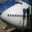
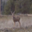
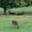
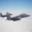
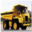
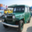
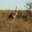
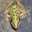

Example 820: otter (55),Example 19301: cloud (23),Example 35541: worm (99),Example 48904: forest (33)
Example 24815: boy (11),Example 40322: squirrel (80),Example 53532: tractor (89),Example 5682: road (68)

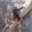
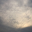
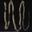
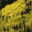
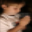
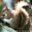
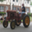
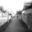

In [6]:
import (
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/types/shapes"

    "github.com/janpfeifer/gonb/gonbui"
)

// sampleToNotebook generates a sample of Cifar-10 and Cifar-100 in a GoNB Jupyter Notebook.
func sampleToNotebook(rows, cols int) {
    dtype := shapes.Float32
    
    // Load data into tensors.
    images10, labels10, err := cifar.LoadCifar10(*flagDataDir, dtype)
    AssertNoError(err)
    images100, labels100, err := cifar.LoadCifar100(*flagDataDir, dtype)
    AssertNoError(err)
    
    sampleTable("Samples from Cifar-10", images10.Local(), labels10.Local(), cifar.C10Labels[:], rows, cols)
    sampleTable("Samples from Cifar-100", images100.Local(), labels100.Local(), cifar.C100FineLabels[:], rows, cols)
}

// sampleTable generates and outputs one html table of samples, sampling rows x cols from the images/labels provided.
func sampleTable(title string, images, labels *tensor.Local, labelsText []string, rows, cols int) {
    htmlRows := make([]string, 0, rows)
    for row := 0; row < rows; row++ {
        cells := make([]string, 0, cols)
        for col := 0; col < cols; col++ {
            cells = append(cells, sampleOneImage(images, labels, labelsText))
        }
        htmlRows = append(htmlRows, fmt.Sprintf("<tr>\n\t<td>%s</td>\n</tr>", strings.Join(cells, "</td>\n\t<td>")))
    }
    htmlTable := fmt.Sprintf("<h3>%s</h3><table>%s</table>\n", title, strings.Join(htmlRows, ""))
    gonbui.DisplayHTML(htmlTable)
}

// sampleOneImage one image from tensor and returns an HTML rendered image with label
func sampleOneImage(images, labels *tensor.Local, labelsText []string) string {
    exampleNum := rand.Intn(images.Shape().Dimensions[0])
    labelsData := tensor.Data[int](labels)
    label := labelsData[exampleNum]
    labelStr := labelsText[label]
    img := cifar.ConvertToGoImage(images, exampleNum)
    imgSrc, err := gonbui.EmbedImageAsPNGSrc(img)
    AssertNoError(err)
    return fmt.Sprintf(`<figure style="padding:4px;text-align: center;"><img width="128" height="128" src="%s"><figcaption style="text-align: center;">Example %d: %s (%d)</figcaption></figure>`, imgSrc, exampleNum, labelStr, label)
}

%%
AssertDownloaded()
rows, cols := 2, 4
sampleToNotebook(rows, cols)

## Training on Cifar-10

### Models Support

In this cell we define 3 functions we are going to use for the modeling:

1. `getBatchedImages`: this will take the `cifar.Dataset` yielded `spec`, and convert the image indices that are given as input, and convert them to the actual batch of images. The whole Cifar-10 dataset is configured as a variable -- so it can be stored in the accelerator memory for faster access. This function will call the `Dataset.GatherImagesGraph` to retrieve it.
1. `normalizeImage` and `normalizeFeatures`: they normalize `x` according to the hyperparameter given in `flagNormalization` flag.


In [7]:
import (
    "flags"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
)

var (
    // ML Manager creation:
    flagNumThreads  = flag.Int("num_threads", -1, "Number of threads. Leave as -1 to use as many as there are cores.")
    flagNumReplicas = flag.Int("num_replicas", 1, "Number of replicas.")
    flagPlatform    = flag.String("platform", "", "Platform to use, if empty uses the default one.")

    // Model hyper-parameters.
    flagL2Regularization = flag.Float64("l2_reg", 0, "L2 regularization on kernels. It doesn't interact well with --batch_norm.")
    flagNormalization    = flag.String("norm", "layer", "Type of normalization to use. Valid values are \"none\", \"batch\", \"layer\".")

    // Model hyperparameters:
    flagNumHiddenLayers = flag.Int("hidden_layers", 8, "Number of hidden layers, stacked with residual connection.")
    flagNumNodes        = flag.Int("num_nodes", 128, "Number of nodes in hidden layers.")
    flagDropoutRate     = flag.Float64("dropout", 0, "Dropout rate")
)

func getBatchedImages(ctx *context.Context, spec any, inputs []*Node) (batchedImages *Node) {
    g := inputs[0].Graph()
    if !g.Ok() {
        return nil
    }

    if spec != nil {
        // spec should hold the dataset that converts the image indices to the actual
        // images, by gathering from a large variable that holds all the images.
        dataset, ok := spec.(*cifar.Dataset)
        if !ok {
            g.SetErrorf("spec given to FNNModelGraph is not a *cifarDataset, instead got %T", spec)
            return nil
        }
        // We assume that batchedImages passed is actually a list of indices, and we need to gather
        // the actual images.
        batchedImages = dataset.GatherImagesGraph(ctx, inputs[0])
    } else {
        // If a spec was not given, we assume the raw images are being fed for inference.
        batchedImages = inputs[0]
    }
    if !batchedImages.Ok() {
        g.SetErrorf("failed to load batch of images")
        return nil
    }
    return
}

func normalizeImage(ctx *context.Context, x *Node) *Node {
    x.AssertRank(4)  // [batch_size, width, height, depth]
    switch *flagNormalization {
    case "layer":
        return layers.LayerNormalization(ctx, x, 1, 2).ScaleNormalization(false).Done()
    case "batch":
        return layers.BatchNormalization(ctx, x, -1).Done()
    case "none":
        return x
    }
    g := x.Graph()
    g.SetErrorf("invalid normalization selected %q -- valid values are batch, layer, none", *flagNormalization)
    return g.InvalidNode()
}

func normalizeFeatures(ctx *context.Context, x *Node) *Node {
    x.AssertRank(2)  // [batch_size, embedding_dim]
    switch *flagNormalization {
    case "layer":
        return layers.LayerNormalization(ctx, x, -1).Done()
    case "batch":
        return layers.BatchNormalization(ctx, x, -1).Done()
    case "none":
        return x
    }
    g := x.Graph()
    g.SetErrorf("invalid normalization selected %q -- valid values are batch, layer, none", *flagNormalization)
    return g.InvalidNode()
}

### Simple FNN model

A trivial model, that can easily get to ~45% accuracy (a random model would do 10%), but hardly much more than that.

Later we are going to define a CNN model to compare, and we just set a placeholder model here for now.

> **Note**: 
>
> * Cifar datasets yields (`Dataset.Yield()`) only the indices to the images of the batch as a `Tensor`. But it provides a `GatherImagesGraph` method that gathers the images from a static variable that holds the whole dataset (~1Gb in memory, stored as float32). We access it through the `getBatchedImatges()` defined above. 


In [8]:
import (
    "flags"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/ml/train/optimizers"
    "github.com/gomlx/gomlx/types/shapes"
)

var DType = shapes.Float32

func FNNModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    g := inputs[0].Graph()
    if !g.Ok() {
        return nil
    }
    batchedImages := getBatchedImages(ctx, spec, inputs)
    if !g.Ok() {
        return nil
    }
    batchSize := batchedImages.Shape().Dimensions[0]
    logits := Reshape(batchedImages, batchSize, -1)
    {
        ctx := ctx.In("Dense_0")
        logits = layers.DenseWithBias(ctx, logits, *flagNumNodes)
        logits = normalizeFeatures(ctx, logits)
    }
    for ii := 1; ii < *flagNumHiddenLayers; ii++ {
        ctx := ctx.In(fmt.Sprintf("Dense_%d", ii))
        // Add layer with residual connection.
        tmp := Sigmoid(logits)
        if *flagDropoutRate > 0 {
            tmp = layers.Dropout(ctx, tmp, Const(g, shapes.CastAsDType(*flagDropoutRate, tmp.DType())))
        }
        tmp = layers.DenseWithBias(ctx, tmp, *flagNumNodes)
        tmp = normalizeFeatures(ctx, tmp)
        logits = Add(logits, tmp)
    }
    logits = Sigmoid(logits)
    logits = layers.DenseWithBias(ctx.In("denseFinal"), logits, len(cifar.C10Labels))
    return []*Node{logits}
}

// Only a placeholder for now.
func CNNModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    return nil   
}

%% --platform=Host

// Let's test that the logits are coming out with the right shape: we want [batch_size, 10], since there are 10 classes.
AssertDownloaded()
manager := BuildManager().NumThreads(*flagNumThreads).NumReplicas(*flagNumReplicas).Platform(*flagPlatform).MustDone()
trainDS, err := cifar.NewDataset("Cifar-10 Batched Train", *flagDataDir, cifar.C10, DType, cifar.Train, 3, false) // loops forever.
AssertNoError(err)

graph := manager.NewGraph("test")
ctx := context.NewContext(manager)
logits := FNNModelGraph(ctx, trainDS, []*Node{graph.Parameter("images", shapes.Make(shapes.Int64, /*Batch Size*/ 3, 1))})
AssertNoError(graph.Error())
AssertNoError(ctx.Error())
fmt.Printf("Logits shape for batch_size=%d: %s\n", 3, logits[0].Shape())


Logits shape for batch_size=3: (Float32)[3 10]


### Training Loop

With a model function defined, let's create our training loop, with the usual bells and whistles: accuracy metrics, progress-bar, plot of metrics, checkpoints.

In [9]:
import (
    "flags"
    
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/ml/train"
    "github.com/gomlx/gomlx/types/slices"
)

var (
    // Training flags:
    flagModel            = flag.String("model", "fnn", "Model type: fnn or cnn.")
    flagNumSteps         = flag.Int("steps", 2000, "Number of gradient descent steps to perform")
    flagBatchSize        = flag.Int("batch", 50, "Batch size for training")
    flagOptimizer        = flag.String("optimizer", "adamw", fmt.Sprintf("Optimizer, options: %v", slices.Keys(optimizers.KnownOptimizers)))
    flagLearningRate     = flag.Float64("learning_rate", 0.0001, "Initial learning rate.")
    flagCheckpoint       = flag.String("checkpoint", "", "Directory save and load checkpoints from. If left empty, no checkpoints are created.")
    flagCheckpointKeep   = flag.Int("checkpoint_keep", 10, "Number of checkpoints to keep, if --checkpoint is set.")
    
    // Training UI:
    flagUseProgressBar = flag.Bool("bar", true, "If to display a progress bar during training")
    flagNumPlotPoints  = flag.Int("plot_points", 50, "Number points to plot.")
)

var (
    // DType used for the model.
    DType = shapes.Float32
    
    // EvalBatchSize can be larger than training, more efficient.
    EvalBatchSize = 2000
)


func trainModel() {
    // Make sure data is downloaded.
    AssertDownloaded()

    // Manager handles creation of ML computation graphs, accelerator resources, etc.
    manager := BuildManager().NumThreads(*flagNumThreads).NumReplicas(*flagNumReplicas).Platform(*flagPlatform).MustDone()
    fmt.Printf("Platform: %s\n", manager.Platform())

    // Create datasets used for training and evaluation.
    trainDS, err := cifar.NewDataset("Cifar-10 Batched Train", *flagDataDir, cifar.C10, DType, cifar.Train, *flagBatchSize, false) // loops forever.
    AssertNoError(err)
    evalOnTestDS, err := cifar.NewDataset("Cifar-10 Eval On Test", *flagDataDir, cifar.C10, DType, cifar.Test, EvalBatchSize, true) // 1 epoch.
    AssertNoError(err)
    evalOnTrainDS, err := cifar.NewDataset("Cifar-10 Eval On Train", *flagDataDir, cifar.C10, DType, cifar.Train, EvalBatchSize, true) // 1 epoch.
    AssertNoError(err)

    // Create closure for model graph building function, that uses statically the dataset
    // used for its `cifar.Dataset.GatherImageGraph`, to convert image indices to the actual images.
    // This is the signature of model function that the train.Trainer accepts.
    modelFn := FNNModelGraph
    if *flagModel == "cnn" {
        modelFn = CNNModelGraph
    }

    // Metrics we are interested.
    meanAccuracyMetric := metrics.NewSparseCategoricalAccuracy("Mean Accuracy", "#acc")
    movingAccuracyMetric := metrics.NewMovingAverageSparseCategoricalAccuracy("Moving Average Accuracy", "~acc", 0.01)

    // Context holds the variables and hyperparameters for the model.
    ctx := context.NewContext(manager)
    ctx.SetParam(optimizers.LearningRateKey, *flagLearningRate)
    ctx.SetParam(layers.L2RegularizationKey, *flagL2Regularization)

    // Checkpoints saving.
    var checkpoint *checkpoints.Handler
    if *flagCheckpoint != "" {
        checkpointPath := data.ReplaceTildeInDir(*flagCheckpoint)
        if !path.IsAbs(checkpointPath) {
            checkpointPath = path.Join(*flagDataDir, checkpointPath)
        }
        var err error
        checkpoint, err = checkpoints.Build(ctx).Dir(checkpointPath).Keep(*flagCheckpointKeep).Done()
        AssertNoError(err)
    }

    // Create a train.Trainer: this object will orchestrate running the model, feeding
    // results to the optimizer, evaluating the metrics, etc. (all happens in trainer.TrainStep)
    trainer := train.NewTrainer(manager, ctx, modelFn,
        losses.SparseCategoricalCrossEntropyLogits,
        optimizers.MustOptimizerByName(*flagOptimizer),
        []metrics.Interface{movingAccuracyMetric}, // trainMetrics
        []metrics.Interface{meanAccuracyMetric})   // evalMetrics

    // Use standard training loop.
    loop := train.NewLoop(trainer)
    if *flagUseProgressBar {
        commandline.AttachProgressBar(loop) // Attaches a progress bar to the loop.
    }

    // Attach a checkpoint.
    if checkpoint != nil {
        train.NTimesDuringLoop(loop, *flagCheckpointKeep, "checkpointing", 100, func(_ *train.Loop, _ []tensor.Tensor) error {
            return checkpoint.Save()
        })
    }

    // Attach a margaid plots.
    if *flagNumPlotPoints > 0 {
        margaid.New(1024, 400, evalOnTrainDS, evalOnTestDS).DynamicUpdates().Attach(loop, *flagNumPlotPoints)
    }

    // Loop for given number of steps.
    _, err = loop.RunSteps(trainDS, *flagNumSteps)
    AssertNoError(err)

    // Finally print an evaluation on train and test datasets.
    fmt.Println()
    err = commandline.ReportEval(trainer, evalOnTrainDS, evalOnTestDS)
    AssertNoError(err)
    fmt.Println()

    // Release memory -- not really needed since we are exiting, just for the example.
    cifar.ResetCache()
}

%% --model=fnn --steps=500 --plot_points=0
trainModel()

Platform: CUDA
Training (500 steps):  100% [========================================] (100 steps/s) [loss=2.058] [~loss=1.934] [~acc=31.40%]        

Results on Cifar-10 Eval On Train:
	Mean Loss (#loss): 1.907
	Mean Accuracy (#acc): 33.26%
Results on Cifar-10 Eval On Test:
	Mean Loss (#loss): 1.907
	Mean Accuracy (#acc): 33.25%



### FNN Model Training

Let's train the FNN for real this time.

In [10]:
%% --model=fnn --steps=10000 --norm=layer
trainModel()

Platform: CUDA


Training (10000 steps):  100% [========================================] (499 steps/s) [loss=1.649] [~loss=1.404] [~acc=50.06%]        


<path vector-effect="non-scaling-stroke" d="M1.768000e+01,5.334238e+00 L3.456962e+01,1.246795e+02 L5.154412e+01,1.463398e+02 L6.851862e+01,1.581767e+02 L8.549312e+01,1.636681e+02 L1.024676e+02,1.648274e+02 L1.194421e+02,1.776405e+02 L1.364166e+02,1.858165e+02 L1.533911e+02,1.773354e+02 L1.703656e+02,1.899045e+02 L1.873401e+02,1.948467e+02 L2.043146e+02,1.950908e+02 L2.212891e+02,1.941755e+02 L2.382636e+02,1.925281e+02 L2.552381e+02,2.005821e+02 L2.722126e+02,2.028397e+02 L2.891871e+02,2.052803e+02 L3.061616e+02,1.995449e+02 L3.231361e+02,2.061955e+02 L3.401106e+02,2.082700e+02 L3.570851e+02,2.137613e+02 L3.740596e+02,2.140054e+02 L3.910341e+02,2.127241e+02 L4.080086e+02,2.210221e+02 L4.249831e+02,2.196798e+02 L4.419576e+02,2.179714e+02 L4.589321e+02,2.205950e+02 L4.759066e+02,2.165680e+02 L4.928811e+02,2.259643e+02 L5.098556e+02,2.240729e+02 L5.268301e+02,2.207171e+02 L5.438045e+02,2.173002e+02 L5.607790e+02,2.266965e+02 L5.777535e+02,2.203510e+02 L5.947280e+02,2.267575e+02 L6.117025e+02,2.249271e+02 L6.286770e+02,2.294422e+02 L6.456515e+02,2.309066e+02 L6.626260e+02,2.303574e+02 L6.796005e+02,2.298083e+02 L6.965750e+02,2.345675e+02 L7.135495e+02,2.310896e+02 L7.305240e+02,2.328590e+02 L7.474985e+02,2.199239e+02 L7.644730e+02,2.397537e+02 L7.814475e+02,2.312116e+02 L7.984220e+02,2.354217e+02 L8.153965e+02,2.417672e+02 L8.323710e+02,2.342624e+02 L8.493455e+02,2.355437e+02 L8.663200e+02,2.337743e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,5.200000e+00 L3.456962e+01,1.217264e+02 L5.154412e+01,1.438016e+02 L6.851862e+01,1.572005e+02 L8.549312e+01,1.632043e+02 L1.024676e+02,1.675364e+02 L1.194421e+02,1.763836e+02 L1.364166e+02,1.827535e+02 L1.533911e+02,1.737843e+02 L1.703656e+02,1.878178e+02 L1.873401e+02,1.932115e+02 L2.043146e+02,1.970432e+02 L2.212891e+02,1.974337e+02 L2.382636e+02,1.946270e+02 L2.552381e+02,2.019854e+02 L2.722126e+02,2.036573e+02 L2.891871e+02,2.074280e+02 L3.061616e+02,2.019366e+02 L3.231361e+02,2.089900e+02 L3.401106e+02,2.141884e+02 L3.570851e+02,2.186547e+02 L3.740596e+02,2.176907e+02 L3.910341e+02,2.197896e+02 L4.080086e+02,2.262816e+02 L4.249831e+02,2.265623e+02 L4.419576e+02,2.251223e+02 L4.589321e+02,2.267941e+02 L4.759066e+02,2.224987e+02 L4.928811e+02,2.319560e+02 L5.098556e+02,2.298571e+02 L5.268301e+02,2.308577e+02 L5.438045e+02,2.254884e+02 L5.607790e+02,2.367030e+02 L5.777535e+02,2.308455e+02 L5.947280e+02,2.371301e+02 L6.117025e+02,2.375450e+02 L6.286770e+02,2.367396e+02 L6.456515e+02,2.413401e+02 L6.626260e+02,2.413645e+02 L6.796005e+02,2.438417e+02 L6.965750e+02,2.462091e+02 L7.135495e+02,2.455989e+02 L7.305240e+02,2.463311e+02 L7.474985e+02,2.315655e+02 L7.644730e+02,2.513831e+02 L7.814475e+02,2.471853e+02 L7.984220e+02,2.510537e+02 L8.153965e+02,2.548000e+02 L8.323710e+02,2.499066e+02 L8.493455e+02,2.487107e+02 L8.663200e+02,2.462457e+02 "/> <path d="M1.768000e+01,1.747621e+01 L3.456962e+01,9.251696e+01 L5.154412e+01,1.324369e+02 L6.851862e+01,1.465925e+02 L8.549312e+01,1.520327e+02 L1.024676e+02,1.620528e+02 L1.194421e+02,1.739560e+02 L1.364166e+02,1.768560e+02 L1.533911e+02,1.781083e+02 L1.703656e+02,1.903197e+02 L1.873401e+02,1.848931e+02 L2.043146e+02,1.933361e+02 L2.212891e+02,1.949344e+02 L2.382636e+02,2.020442e+02 L2.552381e+02,2.055182e+02 L2.722126e+02,1.931626e+02 L2.891871e+02,2.093518e+02 L3.061616e+02,2.066754e+02 L3.231361e+02,2.115768e+02 L3.401106e+02,2.139687e+02 L3.570851e+02,2.081980e+02 L3.740596e+02,2.159419e+02 L3.910341e+02,2.166123e+02 L4.080086e+02,2.115211e+02 L4.249831e+02,2.178243e+02 L4.419576e+02,2.125883e+02 L4.589321e+02,2.212618e+02 L4.759066e+02,2.239542e+02 L4.928811e+02,2.230833e+02 L5.098556e+02,2.284884e+02 L5.268301e+02,2.362296e+02 L5.438045e+02,2.281000e+02 L5.607790e+02,2.299147e+02 L5.777535e+02,2.359677e+02 L5.947280e+02,2.358159e+02 L6.117025e+02,2.390376e+02 L6.286770e+02,2.337464e+02 L6.456515e+02,2.403578e+02 L6.626260e+02,2.356440e+02 L6.796005e+02,2.397805e+02 L6.965750e+02,2.397182e+02 L7.135495e+02,2.476300e+02 L7.3052


Results on Cifar-10 Eval On Train:


<path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.546931e+02 L3.456962e+01,1.843830e+02 L5.154412e+01,1.611981e+02 L6.851862e+01,1.500304e+02 L8.549312e+01,1.418832e+02 L1.024676e+02,1.370555e+02 L1.194421e+02,1.276249e+02 L1.364166e+02,1.237893e+02 L1.533911e+02,1.307531e+02 L1.703656e+02,1.158471e+02 L1.873401e+02,1.129429e+02 L2.043146e+02,1.095010e+02 L2.212891e+02,1.071889e+02 L2.382636e+02,1.121350e+02 L2.552381e+02,1.039930e+02 L2.722126e+02,1.030790e+02 L2.891871e+02,9.764533e+01 L3.061616e+02,1.019646e+02 L3.231361e+02,9.554825e+01 L3.401106e+02,9.494476e+01 L3.570851e+02,9.106808e+01 L3.740596e+02,9.030730e+01 L3.910341e+02,8.803993e+01 L4.080086e+02,8.404134e+01 L4.249831e+02,8.385262e+01 L4.419576e+02,8.403131e+01 L4.589321e+02,8.331934e+01 L4.759066e+02,8.484511e+01 L4.928811e+02,7.884697e+01 L5.098556e+02,8.259938e+01 L5.268301e+02,7.941964e+01 L5.438045e+02,8.240830e+01 L5.607790e+02,7.744646e+01 L5.777535e+02,8.150302e+01 L5.947280e+02,7.542366e+01 L6.117025e+02,7.540212e+01 L6.286770e+02,7.466087e+01 L6.456515e+02,7.194981e+01 L6.626260e+02,7.230194e+01 L6.796005e+02,7.233983e+01 L6.965750e+02,6.936961e+01 L7.135495e+02,7.079259e+01 L7.305240e+02,6.982854e+01 L7.474985e+02,8.004583e+01 L7.644730e+02,6.493241e+01 L7.814475e+02,6.950089e+01 L7.984220e+02,6.681373e+01 L8.153965e+02,6.274711e+01 L8.323710e+02,6.752514e+01 L8.493455e+02,6.969030e+01 L8.663200e+02,7.108193e+01 "/> <path d="M1.768000e+01,2.548000e+02 L3.456962e+01,1.845759e+02 L5.154412e+01,1.608492e+02 L6.851862e+01,1.497133e+02 L8.549312e+01,1.415461e+02 L1.024676e+02,1.365408e+02 L1.194421e+02,1.275429e+02 L1.364166e+02,1.234738e+02 L1.533911e+02,1.303590e+02 L1.703656e+02,1.156176e+02 L1.873401e+02,1.117519e+02 L2.043146e+02,1.086260e+02 L2.212891e+02,1.056096e+02 L2.382636e+02,1.098351e+02 L2.552381e+02,1.020596e+02 L2.722126e+02,1.007697e+02 L2.891871e+02,9.557924e+01 L3.061616e+02,1.000745e+02 L3.231361e+02,9.211617e+01 L3.401106e+02,9.140182e+01 L3.570851e+02,8.764513e+01 L3.740596e+02,8.646489e+01 L3.910341e+02,8.445059e+01 L4.080086e+02,7.913093e+01 L4.249831e+02,7.847748e+01 L4.419576e+02,7.849797e+01 L4.589321e+02,7.765250e+01 L4.759066e+02,7.886589e+01 L4.928811e+02,7.289674e+01 L5.098556e+02,7.566974e+01 L5.268301e+02,7.264244e+01 L5.438045e+02,7.546097e+01 L5.607790e+02,6.915981e+01 L5.777535e+02,7.350109e+01 L5.947280e+02,6.707721e+01 L6.117025e+02,6.709827e+01 L6.286770e+02,6.589754e+01 L6.456515e+02,6.238047e+01 L6.626260e+02,6.215262e+01 L6.796005e+02,6.181670e+01 L6.965750e+02,5.758477e+01 L7.135495e+02,5.832834e+01 L7.305240e+02,5.678100e+01 L7.474985e+02,6.870893e+01 L7.644730e+02,5.168608e+01 L7.814475e+02,5.679065e+01 L7.984220e+02,5.266876e+01 L8.153965e+02,4.917112e+01 L8.323710e+02,5.342404e+01 L8.493455e+02,5.492743e+01 L8.663200e+02,5.708530e+01 " vector-effect="non-scaling-stroke"/> <path d="M1.768000e+01,2.527291e+02 L3.456962e+01,1.940070e+02 L5.154412e+01,1.624862e+02 L6.851862e+01,1.194790e+02 L8.549312e+01,1.607007e+02 L1.024676e+02,1.047267e+02 L1.194421e+02,8.637671e+01 L1.364166e+02,1.065630e+02 L1.533911e+02,1.609089e+02 L1.703656e+02,1.435651e+02 L1.873401e+02,1.351134e+02 L2.043146e+02,1.157702e+02 L2.212891e+02,1.210660e+02 L2.382636e+02,1.061217e+02 L2.552381e+02,1.284541e+02 L2.722126e+02,1.456315e+02 L2.891871e+02,1.021098e+02 L3.061616e+02,1.114462e+02 L3.231361e+02,1.180365e+02 L3.401106e+02,4.350835e+01 L3.570851e+02,9.903596e+01 L3.740596e+02,6.884661e+01 L3.910341e+02,1.282711e+02 L4.080086e+02,9.175212e+01 L4.249831e+02,8.772022e+01 L4.419576e+02,5.146685e+01 L4.589321e+02,8.097394e+01 L4.759066e+02,4.365232e+01 L4.928811e+02,7.101464e+01 L5.098556e+02,1.020066e+02 L5.268301e+02,5.523223e+01 L5.438045e+02,1.288845e+02 L5.607790e+02,3.069593e+01 L5.777535e+02,9.160823e+01 L5.947280e+02,1.495418e+02 L6.117025e+02,7.144128e+01 L6.286770e+02,2.052552e+01 L6.456515e+02,7.608573e+01 L6.626260e+02,5.200000e+00 L6.796005e+02,3.625656e+01 L6.965750e+02,6.487861e+01 L7.135495e+02,4.479910e+01 L7.3052

	Mean Loss (#loss): 1.419
	Mean Accuracy (#acc): 49.49%
Results on Cifar-10 Eval On Test:
	Mean Loss (#loss): 1.485
	Mean Accuracy (#acc): 47.45%



### CNN model for Cifar-10

Let's now properly define our CNN model to compare:

In [11]:
import (
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/types/shapes"
)

func CNNModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    g := inputs[0].Graph()
    if !g.Ok() {
        return nil
    }
    batchedImages := getBatchedImages(ctx, spec, inputs)
    if !g.Ok() {
        return nil
    }
    batchSize := batchedImages.Shape().Dimensions[0]
    logits := batchedImages
    {
        ctx := ctx.In("conv_0")
        logits = layers.Convolution(ctx, logits).Filters(32).KernelSize(3).Done()
        logits = normalizeImage(ctx, logits)
        logits = layers.Relu(logits)
        logits = MaxPool(logits).Window(2).Done()
    }
    {
        ctx := ctx.In("conv_1")
        logits = layers.Convolution(ctx, logits).Filters(64).KernelSize(3).Done()
        logits = normalizeImage(ctx, logits)
        logits = layers.Relu(logits)
        logits = MaxPool(logits).Window(2).Done()
    }
    {
        ctx := ctx.In("conv_2")
        logits = layers.Convolution(ctx, logits).Filters(64).KernelSize(3).Done()
        logits = normalizeImage(ctx, logits)
        logits = Reshape(logits, batchSize, -1)
        logits = layers.Relu(logits)
    }
    {
        ctx := ctx.In("dense_0")
        logits = layers.DenseWithBias(ctx, logits, *flagNumNodes)
        logits = normalizeFeatures(ctx, logits)
    }
    for ii := 1; ii < *flagNumHiddenLayers; ii++ {
        ctx := ctx.In(fmt.Sprintf("dense_%d", ii))
        // Add layer with residual connection.
        tmp := layers.Relu(logits)
        if *flagDropoutRate > 0 {
            tmp = layers.Dropout(ctx, tmp, Const(g, shapes.CastAsDType(*flagDropoutRate, tmp.DType())))
        }
        tmp = layers.DenseWithBias(ctx, tmp, *flagNumNodes)
        tmp = normalizeFeatures(ctx, tmp)
        logits = Add(logits, tmp)
    }
    logits = layers.Relu(logits)
    logits = layers.DenseWithBias(ctx.In("denseFinal"), logits, len(cifar.C10Labels))
    return []*Node{logits}
}

%% --platform=Host
// Let's test that the logits are coming out with the right shape: we want [batch_size, 10], since there are 10 classes.
AssertDownloaded()
manager := BuildManager().NumThreads(*flagNumThreads).NumReplicas(*flagNumReplicas).Platform(*flagPlatform).MustDone()
trainDS, err := cifar.NewDataset("Cifar-10 Batched Train", *flagDataDir, cifar.C10, DType, cifar.Train, *flagBatchSize, false) // loops forever.
AssertNoError(err)

graph := manager.NewGraph("test")
ctx := context.NewContext(manager)
ctx.SetParam(optimizers.LearningRateKey, *flagLearningRate)
logits := CNNModelGraph(ctx, trainDS, []*Node{graph.Parameter("images", shapes.Make(shapes.Int64, /*Batch Size*/ 3, 1))})
AssertNoError(graph.Error())
AssertNoError(ctx.Error())
fmt.Printf("Logits shape for batch_size=%d: %s\n", 3, logits[0].Shape())

Logits shape for batch_size=3: (Float32)[3 10]


### Training the CNN model

CNNs have a much better inductive bias for machine learning on images, and it can easily achieve > 80% accuracy in training data, but only > 65% on test data, due to overfitting.

Likely it would benefit from pre-training the model on a larger unlabeled datasets.

In [12]:
%% --model=cnn --steps=20000 --batch=50 --hidden_layers=2 --l2_reg=0.01 --dropout=0.1 --norm=batch
trainModel()

Platform: CUDA


Training (20000 steps):  100% [========================================] (436 steps/s) [loss=1.108] [~loss=1.202] [~acc=85.73%]        


<path vector-effect="non-scaling-stroke" d="M1.768000e+01,5.782451e+00 L3.461121e+01,1.091009e+02 L5.158486e+01,1.259125e+02 L6.855851e+01,1.433859e+02 L8.553216e+01,1.502032e+02 L1.025058e+02,1.668824e+02 L1.194795e+02,1.711515e+02 L1.364531e+02,1.790278e+02 L1.534268e+02,1.856797e+02 L1.704004e+02,1.749904e+02 L1.873741e+02,1.849516e+02 L2.043477e+02,1.874005e+02 L2.213214e+02,1.866725e+02 L2.382950e+02,1.839919e+02 L2.552686e+02,1.927948e+02 L2.722423e+02,1.954092e+02 L2.892159e+02,1.977258e+02 L3.061896e+02,1.975272e+02 L3.231632e+02,1.948135e+02 L3.401369e+02,1.993142e+02 L3.571105e+02,1.968322e+02 L3.740842e+02,2.049071e+02 L3.910578e+02,1.852825e+02 L4.080315e+02,1.911070e+02 L4.250051e+02,2.008696e+02 L4.419788e+02,2.039805e+02 L4.589524e+02,1.974941e+02 L4.759261e+02,2.023920e+02 L4.928997e+02,1.942509e+02 L5.098734e+02,2.042783e+02 L5.268470e+02,2.018294e+02 L5.438207e+02,2.055359e+02 L5.607943e+02,2.022596e+02 L5.777680e+02,1.908754e+02 L5.947416e+02,2.014653e+02 L6.117153e+02,2.038812e+02 L6.286889e+02,2.038812e+02 L6.456626e+02,2.059992e+02 L6.626362e+02,2.084150e+02 L6.796099e+02,2.104999e+02 L6.965835e+02,2.044107e+02 L7.135572e+02,2.045100e+02 L7.305308e+02,2.067603e+02 L7.475045e+02,2.092755e+02 L7.644781e+02,2.033848e+02 L7.814518e+02,2.032524e+02 L7.984254e+02,1.966998e+02 L8.153991e+02,2.080179e+02 L8.323727e+02,2.083819e+02 L8.493464e+02,2.044769e+02 L8.663200e+02,2.035171e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,5.200000e+00 L3.461121e+01,1.112189e+02 L5.158486e+01,1.297844e+02 L6.855851e+01,1.487934e+02 L8.553216e+01,1.569676e+02 L1.025058e+02,1.764266e+02 L1.194795e+02,1.816091e+02 L1.364531e+02,1.915240e+02 L1.534268e+02,1.995327e+02 L1.704004e+02,1.906437e+02 L1.873741e+02,2.025706e+02 L2.043477e+02,2.054895e+02 L2.213214e+02,2.053770e+02 L2.382950e+02,2.044107e+02 L2.552686e+02,2.158214e+02 L2.722423e+02,2.196007e+02 L2.892159e+02,2.228174e+02 L3.061896e+02,2.231417e+02 L3.231632e+02,2.218510e+02 L3.401369e+02,2.258620e+02 L3.571105e+02,2.252200e+02 L3.740842e+02,2.335794e+02 L3.910578e+02,2.126576e+02 L4.080315e+02,2.183497e+02 L4.250051e+02,2.311173e+02 L4.419788e+02,2.366307e+02 L4.589524e+02,2.291713e+02 L4.759261e+02,2.340096e+02 L4.928997e+02,2.241213e+02 L5.098734e+02,2.376566e+02 L5.268470e+02,2.338971e+02 L5.438207e+02,2.397349e+02 L5.607943e+02,2.359886e+02 L5.777680e+02,2.220628e+02 L5.947416e+02,2.344663e+02 L6.117153e+02,2.409328e+02 L6.286889e+02,2.374845e+02 L6.456626e+02,2.422897e+02 L6.626362e+02,2.472008e+02 L6.796099e+02,2.502586e+02 L6.965835e+02,2.423294e+02 L7.135572e+02,2.436531e+02 L7.305308e+02,2.436002e+02 L7.475045e+02,2.506558e+02 L7.644781e+02,2.435869e+02 L7.814518e+02,2.438054e+02 L7.984254e+02,2.362600e+02 L8.153991e+02,2.507815e+02 L8.323727e+02,2.522906e+02 L8.493464e+02,2.468632e+02 L8.663200e+02,2.468698e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,1.077959e+01 L3.461121e+01,1.021608e+02 L5.158486e+01,1.299108e+02 L6.855851e+01,1.500790e+02 L8.553216e+01,1.663797e+02 L1.025058e+02,1.735946e+02 L1.194795e+02,1.802525e+02 L1.364531e+02,1.854637e+02 L1.534268e+02,1.959182e+02 L1.704004e+02,1.952791e+02 L1.873741e+02,2.032329e+02 L2.043477e+02,2.079534e+02 L2.213214e+02,2.102158e+02 L2.382950e+02,2.157069e+02 L2.552686e+02,2.177472e+02 L2.722423e+02,2.185787e+02 L2.892159e+02,2.204274e+02 L3.061896e+02,2.247833e+02 L3.231632e+02,2.249612e+02 L3.401369e+02,2.298318e+02 L3.571105e+02,2.282572e+02 L3.740842e+02,2.304541e+02 L3.910578e+02,2.314956e+02 L4.080315e+02,2.337405e+02 L4.250051e+02,2.334808e+02 L4.419788e+02,2.366479e+02 L4.589524e+02,2.337537e+02 L4.759261e+02,2.352476e+02 L4.928997e+02,2.376992e+02 L5.098734e+02,2.380909e+02 L5.268470e+02,2.420830e+02 L5.438207e+02,2.394279e+02 L5.607943e+02,2.406598e+02 L5.777680e+02,2.434795e+02 L5.947416e+02,2.415339e+02 L6.117153e+02,2.438213e+02 L6.286889e+02,2.442511e+02 L6.456626e+02,2.446183e+02 L6.626362e+02,2.447559e+02 L6.796099e+02,2.454866e+02 L6.965835e+02,2.478782e+02


Results on Cifar-10 Eval On Train:


<path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.547666e+02 L3.461121e+01,1.974914e+02 L5.158486e+01,1.628443e+02 L6.855851e+01,1.369863e+02 L8.553216e+01,1.183100e+02 L1.025058e+02,1.027208e+02 L1.194795e+02,9.109196e+01 L1.364531e+02,8.133835e+01 L1.534268e+02,7.328902e+01 L1.704004e+02,6.848776e+01 L1.873741e+02,6.153473e+01 L2.043477e+02,5.665859e+01 L2.213214e+02,5.261758e+01 L2.382950e+02,4.914094e+01 L2.552686e+02,4.440817e+01 L2.722423e+02,4.116733e+01 L2.892159e+02,3.805112e+01 L3.061896e+02,3.575625e+01 L3.231632e+02,3.386061e+01 L3.401369e+02,3.134138e+01 L3.571105e+02,2.981112e+01 L3.740842e+02,2.711962e+01 L3.910578e+02,2.873429e+01 L4.080315e+02,2.713247e+01 L4.250051e+02,2.381379e+01 L4.419788e+02,2.251501e+01 L4.589524e+02,2.257406e+01 L4.759261e+02,2.125744e+01 L4.928997e+02,2.196109e+01 L5.098734e+02,1.988343e+01 L5.268470e+02,1.988347e+01 L5.438207e+02,1.874816e+01 L5.607943e+02,1.870525e+01 L5.777680e+02,2.007093e+01 L5.947416e+02,1.801532e+01 L6.117153e+02,1.730438e+01 L6.286889e+02,1.721571e+01 L6.456626e+02,1.658527e+01 L6.626362e+02,1.575893e+01 L6.796099e+02,1.527670e+01 L6.965835e+02,1.606760e+01 L7.135572e+02,1.582944e+01 L7.305308e+02,1.545254e+01 L7.475045e+02,1.482682e+01 L7.644781e+02,1.555764e+01 L7.814518e+02,1.547055e+01 L7.984254e+02,1.647321e+01 L8.153991e+02,1.450671e+01 L8.323727e+02,1.408300e+01 L8.493464e+02,1.499689e+01 L8.663200e+02,1.479701e+01 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.548000e+02 L3.461121e+01,1.972860e+02 L5.158486e+01,1.624606e+02 L6.855851e+01,1.364075e+02 L8.553216e+01,1.174230e+02 L1.025058e+02,1.014812e+02 L1.194795e+02,8.959219e+01 L1.364531e+02,7.950752e+01 L1.534268e+02,7.118041e+01 L1.704004e+02,6.615192e+01 L1.873741e+02,5.874126e+01 L2.043477e+02,5.372573e+01 L2.213214e+02,4.947516e+01 L2.382950e+02,4.579372e+01 L2.552686e+02,4.087583e+01 L2.722423e+02,3.744612e+01 L2.892159e+02,3.434207e+01 L3.061896e+02,3.181592e+01 L3.231632e+02,2.986771e+01 L3.401369e+02,2.740032e+01 L3.571105e+02,2.565892e+01 L3.740842e+02,2.293517e+01 L3.910578e+02,2.452030e+01 L4.080315e+02,2.283491e+01 L4.250051e+02,1.958297e+01 L4.419788e+02,1.805400e+01 L4.589524e+02,1.815984e+01 L4.759261e+02,1.668654e+01 L4.928997e+02,1.740214e+01 L5.098734e+02,1.514250e+01 L5.268470e+02,1.510566e+01 L5.438207e+02,1.366830e+01 L5.607943e+02,1.375882e+01 L5.777680e+02,1.517941e+01 L5.947416e+02,1.296980e+01 L6.117153e+02,1.191756e+01 L6.286889e+02,1.196476e+01 L6.456626e+02,1.115712e+01 L6.626362e+02,1.027330e+01 L6.796099e+02,9.544751e+00 L6.965835e+02,1.040829e+01 L7.135572e+02,9.979688e+00 L7.305308e+02,9.724246e+00 L7.475045e+02,8.703127e+00 L7.644781e+02,9.376144e+00 L7.814518e+02,9.146841e+00 L7.984254e+02,9.822588e+00 L8.153991e+02,7.937540e+00 L8.323727e+02,7.513405e+00 L8.493464e+02,8.222918e+00 L8.663200e+02,7.969063e+00 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.540512e+02 L3.461121e+01,1.957063e+02 L5.158486e+01,1.635943e+02 L6.855851e+01,1.329314e+02 L8.553216e+01,1.171871e+02 L1.025058e+02,9.707036e+01 L1.194795e+02,8.597528e+01 L1.364531e+02,7.940010e+01 L1.534268e+02,7.326089e+01 L1.704004e+02,6.358477e+01 L1.873741e+02,5.645638e+01 L2.043477e+02,5.685158e+01 L2.213214e+02,4.978958e+01 L2.382950e+02,4.609490e+01 L2.552686e+02,4.083126e+01 L2.722423e+02,3.683841e+01 L2.892159e+02,3.632976e+01 L3.061896e+02,3.021928e+01 L3.231632e+02,2.950966e+01 L3.401369e+02,2.461433e+01 L3.571105e+02,2.249599e+01 L3.740842e+02,2.377814e+01 L3.910578e+02,1.847016e+01 L4.080315e+02,2.177741e+01 L4.250051e+02,2.030428e+01 L4.419788e+02,1.686512e+01 L4.589524e+02,1.656543e+01 L4.759261e+02,1.754827e+01 L4.928997e+02,1.561275e+01 L5.098734e+02,1.563734e+01 L5.268470e+02,1.393024e+01 L5.438207e+02,1.245080e+01 L5.607943e+02,1.145443e+01 L5.777680e+02,1.058669e+01 L5.947416e+02,1.531024e+01 L6.117153e+02,1.225094e+01 L6.286889e+02,1.049237e+01 L6.456626e+02,1.106358e+01 L6.626362e+02,1.042375e+01 L6.796099e+02,8.595366e+00 L6.965835e+02,9.967917e+00

	Mean Loss (#loss): 1.245
	Mean Accuracy (#acc): 83.34%
Results on Cifar-10 Eval On Test:
	Mean Loss (#loss): 1.585
	Mean Accuracy (#acc): 70.24%

